In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append('../src')
from recommenders.item_based_rs import ItemBasedRecommenderSystem
from recommenders.user_based_rs import UserBasedRecommenderSystem
from recommenders.item_regression_rs import ItemBasedRegressionRecommenderSystem
from recommenders.non_personalized_rs import NonPersonalizedRecommenderSystem


# Experiments

In [16]:
def evaluate_recommender_system(recommender_system, neighborhood_size, similarity_measure, x):
    mae_for_each_neighborhood_size = []
    
    folder_path = '/kaggle/input/movielens-ratings/train_' + str(x)
    train_path = folder_path + '/train.csv'
    test_path = folder_path + '/test.csv'
    rating_matrix_path = folder_path + '/rating_matrix.npy'
    sim_matrix_path = folder_path + '/similarity_matrix.npy'
    
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    if recommender_system == "item_based":
        rs = ItemBasedRecommenderSystem(train_df, neighborhood_size, rating_matrix_path, sim_matrix_path, similarity_measure)
    elif recommender_system == "user_based":
        rs = UserBasedRecommenderSystem(train_df, neighborhood_size, rating_matrix_path, sim_matrix_path, similarity_measure)
    elif recommender_system == "item_regression":
        qtus_path = folder_path + '/qtus.pkl'
        optimizer=torch.optim.Adam
        epochs=8
        lr=0.003
        weight_decay=0
        rs = ItemBasedRegressionRecommenderSystem(train_df, neighborhood_size, qtus_path, rating_matrix_path, sim_matrix_path, similarity_measure, optimizer, epochs, lr, weight_decay)
    elif recommender_system == "non_personalized":
        rs = NonPersonalizedRecommenderSystem(train_df, rating_matrix_path)

    rs.fit()
    mae = rs.evaluate(test_df)

    print(f"Recommendation system: {recommender_system}, similarity measure: {similarity_measure}, neighborhood size: {neighborhood_size}, MAE: {mae}")
    return rs


In [18]:
rs = evaluate_recommender_system("item_based", 30, 'pure_cosine', x=0.3)

FileNotFoundError: [Errno 2] No such file or directory: 'pure_cosine'

## 1. Effect of Similarity Algorithm

In [4]:
results_df = pd.read_csv('../experiment_results.csv')
results_df.head()

,model,neighborhood_size,x,similarity_function,MAE
0,item_based,30,0.8,pure_cosine,0.818646
1,item_based,30,0.8,corr,0.898281
2,item_based,30,0.9,pure_cosine,0.815782
3,item_based,30,0.8,adjusted_cosine,NaN
4,item_based,10,0.8,pure_cosine,0.862526


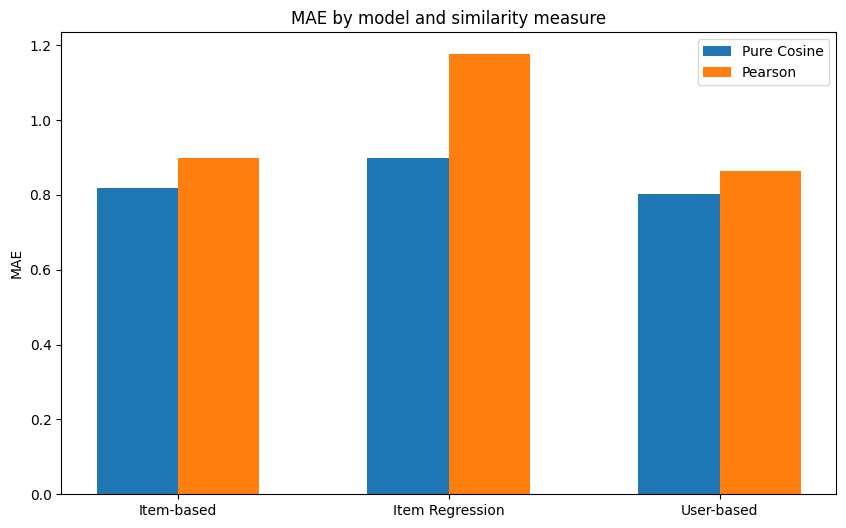

In [3]:
ib_MAEs = results_df.loc[(results_df['model'] == 'item_based') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]
ibr_MAEs = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]
ub_MAEs = results_df.loc[(results_df['model'] == 'user_based') & (results_df['x'] == 0.8) & (results_df['neighborhood_size'] == 30)].sort_values(by='similarity_function')['MAE'].values[1:]

labels = ['Item-based', 'Item Regression', 'User-based']
pure_cosine = [ib_MAEs[1], ibr_MAEs[1], ub_MAEs[1]]
pearson = [ib_MAEs[0], ibr_MAEs[0], ub_MAEs[0]]

x = np.arange(len(labels))
width = 0.3 

fig_ex_1 = plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pure_cosine, width, label='Pure Cosine')
plt.bar(x + width/2, pearson, width, label='Pearson')

plt.ylabel('MAE')
plt.title('MAE by model and similarity measure')
plt.xticks(x, labels)
plt.legend()


plt.show()


In [13]:
fig_ex_1.savefig('../figures/ex_1.png')

NameError: name 'fig_ex_1' is not defined

## 2.  Sensitivity of Training/Test Ratio

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7112\4102084561.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xs, ub_MAEs_for_each_x, 'r^-', color='blue', label='usr-usr(pure_cosine)')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7112\4102084561.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c*-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(xs, np_MAEs_for_each_x, 'c*-', color='green', label='non-per')


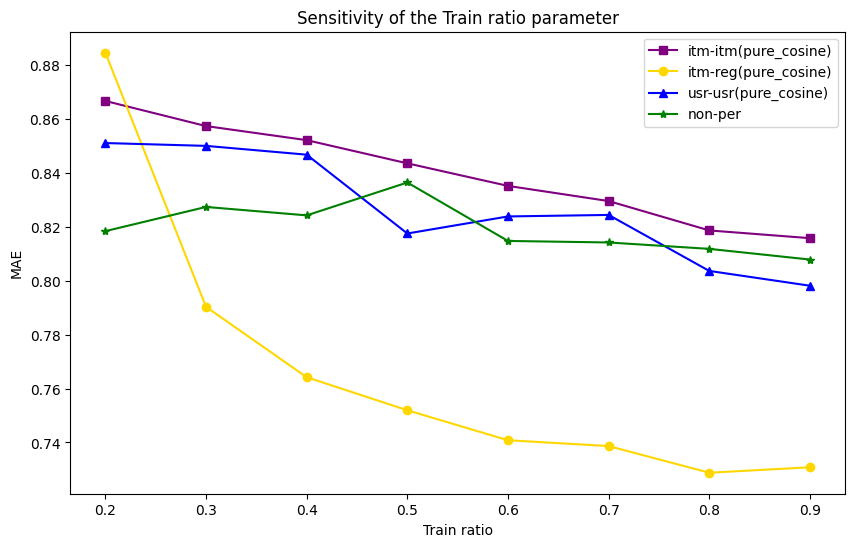

In [12]:
ib_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'item_based') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
ibr_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['neighborhood_size'] == 200) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
ub_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'user_based') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values
np_MAEs_for_each_x = results_df.loc[(results_df['model'] == 'nonper') & (results_df['neighborhood_size'] == 30) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='x')['MAE'].values

xs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
fig_ex_2 = plt.figure(figsize=(10, 6))
plt.plot(xs, ib_MAEs_for_each_x, 's-', color='purple', label='itm-itm(pure_cosine)')
plt.plot(xs, ibr_MAEs_for_each_x, 'o-', color='gold', label='itm-reg(pure_cosine)')
plt.plot(xs, ub_MAEs_for_each_x, 'r^-', color='blue', label='usr-usr(pure_cosine)') 
plt.plot(xs, np_MAEs_for_each_x, 'c*-', color='green', label='non-per')  

plt.title('Sensitivity of the Train ratio parameter')
plt.xlabel('Train ratio')
plt.ylabel('MAE')
plt.legend()

In [14]:
fig_ex_2.savefig('../figures/ex_2.png')

## 3.  Experiments with neighborhood size

[0.86252567 0.82856714 0.81864638 0.81593486 0.817475   0.81999927
 0.82331218 0.82630004 0.82994453 0.83391247 0.8367868  0.83872324]


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7112\784454415.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(neighborhood_sizes, ub_MAEs_for_each_neighborhood_size, 'r^-', color='blue', label='usr-usr(pure_cosine)')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7112\784454415.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c*-" (-> color='c'). The keyword argument will take precedence.
  plt.plot(neighborhood_sizes, np_MAEs_for_each_neighborhood_size, 'c*-', color='green', label='non-per')


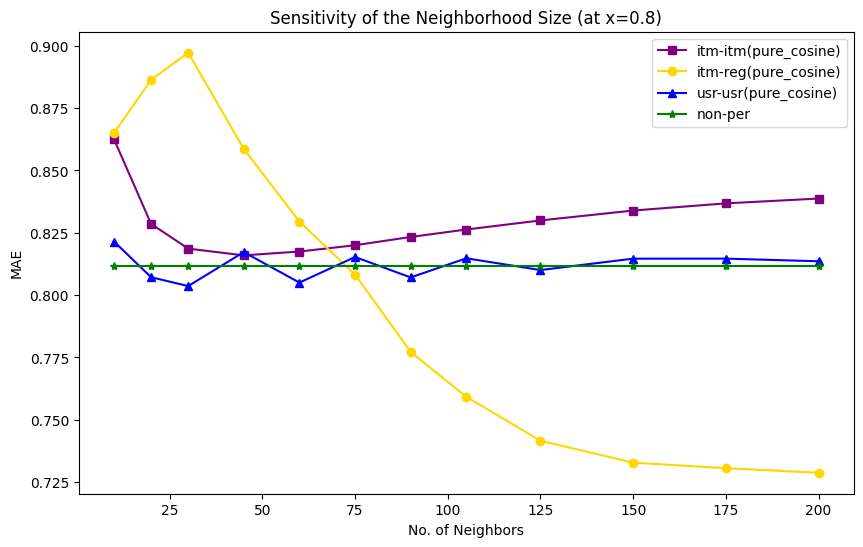

In [11]:
ib_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'item_based') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
ibr_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'item_regression') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
ub_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'user_based') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values
np_MAEs_for_each_neighborhood_size = results_df.loc[(results_df['model'] == 'nonper') & (results_df['x'] == 0.8) & (results_df['similarity_function'] == 'pure_cosine')].sort_values(by='neighborhood_size')['MAE'].values

neighborhood_sizes = [10, 20, 30, 45, 60, 75, 90, 105, 125, 150, 175, 200]
fig_ex_3 = plt.figure(figsize=(10, 6))
print(ib_MAEs_for_each_neighborhood_size)
plt.plot(neighborhood_sizes, ib_MAEs_for_each_neighborhood_size, 's-', color='purple', label='itm-itm(pure_cosine)')
plt.plot(neighborhood_sizes, ibr_MAEs_for_each_neighborhood_size, 'o-', color='gold', label='itm-reg(pure_cosine)')
plt.plot(neighborhood_sizes, ub_MAEs_for_each_neighborhood_size, 'r^-', color='blue', label='usr-usr(pure_cosine)')  
plt.plot(neighborhood_sizes, np_MAEs_for_each_neighborhood_size, 'c*-', color='green', label='non-per')  

plt.title('Sensitivity of the Neighborhood Size (at x=0.8)')
plt.xlabel('No. of Neighbors')
plt.ylabel('MAE')
plt.legend()



In [15]:
fig_ex_3.savefig('../figures/ex_3.png')